<a href="https://colab.research.google.com/github/rakeshgovindsuresh/Python-Practice/blob/main/DissertationPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/cleaned_dataset.csv'  # Replace with the actual path to your dataset
dataset = pd.read_csv(file_path)

# 1. Batsman Statistics

# Total Runs, Balls Faced, Number of 4s and 6s
batsman_stats = dataset.groupby('batter').agg(
    total_runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count'),
    fours=('batsman_runs', lambda x: (x == 4).sum()),
    sixes=('batsman_runs', lambda x: (x == 6).sum())
).reset_index()

# Calculate Strike Rate for Batsman
batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['balls_faced']) * 100

# 2. Bowler Statistics

# Total Wickets, Runs Conceded, and Balls Bowled (to calculate overs)
bowler_stats = dataset.groupby('bowler').agg(
    total_wickets=('is_wicket', 'sum'),
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('ball', 'count')
).reset_index()

# Calculate Overs Bowled and Economy Rate
bowler_stats['overs_bowled'] = bowler_stats['balls_bowled'] / 6
bowler_stats['economy_rate'] = bowler_stats['runs_conceded'] / bowler_stats['overs_bowled']

# 3. Batsman vs. Bowler Comparison

# Average Runs per Ball (Batsman vs. Bowler)
batsman_bowler_avg_runs = dataset.groupby(['batter', 'bowler'])['batsman_runs'].mean().reset_index()
batsman_bowler_avg_runs.columns = ['batter', 'bowler', 'avg_runs_per_ball_batsman_vs_bowler']

# Strike Rate (Batsman vs. Bowler)
batsman_bowler_stats = dataset.groupby(['batter', 'bowler']).agg(
    total_runs=('batsman_runs', 'sum'),
    total_balls=('ball', 'count')
).reset_index()
batsman_bowler_stats['strike_rate_batsman_vs_bowler'] = (batsman_bowler_stats['total_runs'] / batsman_bowler_stats['total_balls']) * 100

# Dismissal Rate (Batsman vs. Bowler)
dismissals = dataset[dataset['is_wicket'] == 1].groupby(['batter', 'bowler']).size().reset_index(name='dismissals')
dismissal_rate = dismissals.merge(batsman_bowler_stats[['batter', 'bowler', 'total_balls']], on=['batter', 'bowler'])
dismissal_rate['dismissal_rate_batsman_vs_bowler'] = dismissal_rate['total_balls'] / dismissal_rate['dismissals']

# 4. Percentage of Runs Distribution per Batsman vs. Bowler

# Calculate the percentage of balls that resulted in 6s, 4s, 3s, 2s, 1s, and 0 runs
runs_distribution = dataset.groupby(['batter', 'bowler', 'batsman_runs']).size().unstack(fill_value=0).reset_index()

# Calculate percentages for each type of run
numeric_columns = runs_distribution.select_dtypes(include='number').columns  # Only sum numeric columns
total_balls_faced = runs_distribution[numeric_columns].sum(axis=1)
runs_distribution['percent_6s'] = (runs_distribution[6] / total_balls_faced) * 100
runs_distribution['percent_4s'] = (runs_distribution[4] / total_balls_faced) * 100
runs_distribution['percent_3s'] = (runs_distribution[3] / total_balls_faced) * 100
runs_distribution['percent_2s'] = (runs_distribution[2] / total_balls_faced) * 100
runs_distribution['percent_1s'] = (runs_distribution[1] / total_balls_faced) * 100
runs_distribution['percent_0s'] = (runs_distribution[0] / total_balls_faced) * 100

# Calculate the percentage of dismissals
dismissal_percentage = dismissal_rate.copy()
dismissal_percentage['percent_dismissals'] = (dismissal_percentage['dismissals'] / dismissal_percentage['total_balls']) * 100

# Merge percentage distributions with the main batsman-bowler comparison DataFrame
batsman_bowler_comparison = batsman_bowler_avg_runs.merge(
    batsman_bowler_stats[['batter', 'bowler', 'strike_rate_batsman_vs_bowler']],
    on=['batter', 'bowler']
).merge(
    dismissal_rate[['batter', 'bowler', 'dismissal_rate_batsman_vs_bowler']],
    on=['batter', 'bowler'], how='left'
).merge(
    runs_distribution[['batter', 'bowler', 'percent_6s', 'percent_4s', 'percent_3s', 'percent_2s', 'percent_1s', 'percent_0s']],
    on=['batter', 'bowler'], how='left'
).merge(
    dismissal_percentage[['batter', 'bowler', 'percent_dismissals']],
    on=['batter', 'bowler'], how='left'
)

# 5. Contextual Features

# Over Context (Powerplay, Middle Overs, Death Overs)
def categorize_over(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle Overs'
    else:
        return 'Death Overs'

dataset['over_context'] = dataset['over'].apply(categorize_over)

# Required Run Rate
dataset['required_run_rate'] = (dataset['target_runs'] - dataset.groupby('match_id')['total_runs'].cumsum()) / (dataset['target_overs'] * 6 - dataset.groupby('match_id')['ball'].cumsum())

# Current Run Rate
dataset['current_run_rate'] = dataset.groupby('match_id')['total_runs'].cumsum() / (dataset['over'] + dataset['ball'] / 6)

# Wickets in Hand
dataset['wickets_in_hand'] = 10 - dataset.groupby('match_id')['is_wicket'].cumsum()

# 6. Batsman’s Recent Form Features

# Batsman’s Recent Average Runs
def calculate_recent_average(df, window=20):
    df['recent_avg_runs'] = df.groupby('batter')['batsman_runs'].rolling(window).mean().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_average(dataset)

# Batsman’s Recent Boundary Rate
def calculate_recent_boundaries(df, window=20):
    df['is_boundary'] = df['batsman_runs'].isin([4, 6])
    df['recent_boundary_rate'] = df.groupby('batter')['is_boundary'].rolling(window).mean().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_boundaries(dataset)

# 7. Bowler’s Recent Performance Features

# Bowler’s Recent Economy Rate
def calculate_recent_economy(df, window=12):  # Assuming an over contains 6 balls
    df['recent_runs_conceded'] = df.groupby('bowler')['total_runs'].rolling(window).sum().reset_index(level=0, drop=True)
    df['recent_economy_rate'] = df['recent_runs_conceded'] / (window / 6)
    return df

dataset = calculate_recent_economy(dataset)

# Bowler’s Recent Wicket-Taking Ability
def calculate_recent_wickets(df, window=12):
    df['recent_wickets'] = df.groupby('bowler')['is_wicket'].rolling(window).sum().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_wickets(dataset)

# 8. Partnership Information

# Calculate Partnership Runs and Partnership Balls Faced
dataset['partnership_runs'] = dataset.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].cumsum() - dataset['batsman_runs']
dataset['partnership_balls_faced'] = dataset.groupby(['match_id', 'inning', 'batting_team']).cumcount() + 1

# 9. Match Pressure Metrics

# Pressure Factor = Required Run Rate / (Wickets in Hand + 1)
dataset['pressure_factor'] = dataset['required_run_rate'] / (dataset['wickets_in_hand'] + 1)

# Merge Everything into One DataFrame

# Merge batsman stats
final_dataset = dataset.merge(batsman_stats, left_on='batter', right_on='batter', how='left')

# Merge bowler stats
final_dataset = final_dataset.merge(bowler_stats, left_on='bowler', right_on='bowler', how='left')

# Merge batsman vs. bowler comparison
final_dataset = final_dataset.merge(batsman_bowler_comparison, on=['batter', 'bowler'], how='left')

# Save the final dataset to a CSV file
final_file_path = '/content/newFeatureEngdataset.csv'
final_dataset.to_csv(final_file_path, index=False)

print(f"The final combined dataset has been saved as {final_file_path}")



<ipython-input-2-98143e734e55>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


The final combined dataset has been saved as /content/newFeatureEngdataset.csv


In [ ]:
import pandas as pd

# Load the datasets
df_csv = pd.read_csv('newFeatureEngdataset.csv', dtype=str, low_memory=False)
df_excel = pd.read_excel('updated_stadium_stats_with_wankhede_stadium (1).xlsx')

# Strip any whitespace from the 'venue' column and convert to lowercase for consistent merging
df_csv['venue'] = df_csv['venue'].str.strip().str.lower()
df_excel['venue'] = df_excel['venue'].str.strip().str.lower()

# Prefix all columns from df_excel except 'venue' with 'venue_'
df_excel = df_excel.rename(columns=lambda x: f"venue_{x}" if x != 'venue' else x)

# Check for unique values in the 'venue' column to identify any mismatches
print("Unique venues in CSV file:", df_csv['venue'].unique())
print("Unique venues in Excel file:", df_excel['venue'].unique())

# Merge the datasets (left join to preserve all rows from df_csv)
merged_df = pd.merge(df_csv, df_excel, on='venue', how='left')

# Save the merged DataFrame
merged_df.to_excel('newmergedFeaturePlusVenueStats.xlsx', index=False)
merged_df.to_csv('newmergedFeaturePlusVenueStats.csv', index=False)

# Print the shape of the merged dataframe to check if rows are preserved
print("Shape of the merged DataFrame:", merged_df.shape)


Unique venues in CSV file: ['m chinnaswamy stadium' 'punjab cricket association stadium, mohali'
 'feroz shah kotla' 'wankhede stadium' 'eden gardens'
 'sawai mansingh stadium' 'rajiv gandhi international stadium, uppal'
 'ma chidambaram stadium, chepauk' 'dr dy patil sports academy' 'newlands'
 "st george's park" 'kingsmead' 'supersport park' 'buffalo park'
 'new wanderers stadium' 'de beers diamond oval' 'outsurance oval'
 'brabourne stadium' 'sardar patel stadium, motera' 'barabati stadium'
 'brabourne stadium, mumbai'
 'vidarbha cricket association stadium, jamtha'
 'himachal pradesh cricket association stadium' 'nehru stadium'
 'holkar cricket stadium'
 'dr. y.s. rajasekhara reddy aca-vdca cricket stadium'
 'subrata roy sahara stadium' 'maharashtra cricket association stadium'
 'shaheed veer narayan singh international stadium'
 'jsca international stadium complex' 'sheikh zayed stadium'
 'sharjah cricket stadium' 'dubai international cricket stadium'
 'punjab cricket association 

In [ ]:
import pandas as pd

# Load the datasets
df_csv = pd.read_csv('/content/newmergedFeaturePlusVenueStats.csv', dtype=str, low_memory=False)


columns_to_drop = ['match_id','team1','team2','venue_City','venue_Country','venue_First Match','venue_Last T20 Match','venue_Also or previously Known as','season','super_over','non_striker','venue_Best Bowling','venue_Highest Individual Innings']

df_csv = df_csv.drop(columns=columns_to_drop)

# Check the remaining columns
print(df_csv.columns)

Index(['venue', 'result_margin', 'target_runs', 'target_overs', 'inning',
       'batting_team', 'bowling_team', 'over', 'ball', 'batter', 'bowler',
       'batsman_runs', 'extra_runs', 'total_runs_x', 'extras_type',
       'is_wicket', 'over_context', 'required_run_rate', 'current_run_rate',
       'wickets_in_hand', 'recent_avg_runs', 'is_boundary',
       'recent_boundary_rate', 'recent_runs_conceded', 'recent_economy_rate',
       'recent_wickets', 'partnership_runs', 'partnership_balls_faced',
       'pressure_factor', 'total_runs_y', 'balls_faced', 'fours', 'sixes',
       'strike_rate', 'total_wickets', 'runs_conceded', 'balls_bowled',
       'overs_bowled', 'economy_rate', 'avg_runs_per_ball_batsman_vs_bowler',
       'strike_rate_batsman_vs_bowler', 'dismissal_rate_batsman_vs_bowler',
       'percent_6s', 'percent_4s', 'percent_3s', 'percent_2s', 'percent_1s',
       'percent_0s', 'percent_dismissals', 'venue_Matches Played',
       'venue_Matches Won Batting First', 'venue_Ma

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder



# List of columns you want to convert to categorical and apply label encoding
columns_to_convert = ['venue', 'batter', 'bowler', 'extras_type', 'over_context', 'is_boundary']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each column
for column in columns_to_convert:
    df_csv[column] = label_encoder.fit_transform(df_csv[column])

# Verify the changes
print(df_csv.dtypes)
output_csv_path = '/content/newfiletocheckconv.csv'  # Replace with your desired output file path
df_csv.to_csv(output_csv_path, index=False)

venue                                 int64
result_margin                        object
target_runs                          object
target_overs                         object
inning                               object
                                      ...  
venue_Lowest Team Innings            object
venue_Highest Run Chase Achieved     object
venue_Average Runs per Wicket        object
venue_Average Runs per Over          object
venue_Average Score Batting First    object
Length: 61, dtype: object


In [ ]:
import pandas as pd
file_path = "/content/newfiletocheckconv.csv"

df_csv = pd.read_csv(file_path)
columns_to_drop = ['batting_team','bowling_team']
df_csv = df_csv.drop(columns=columns_to_drop)
columns_to_extract = ['venue_Highest Team Innings', 'venue_Lowest Team Innings',
                      'venue_Highest Run Chase Achieved']
for column in columns_to_extract:
    # Extract the numeric part, handle NaN, and convert to integers
    df_csv[column] = df_csv[column].str.extract(r'(\d+)', expand=False)
    df_csv[column] = df_csv[column].fillna(0).astype(int)


# Verify the changes
print(df_csv[columns_to_extract].head())
df_csv.fillna(0, inplace=True)
output_csv_path = '/content/newfullyFeaturedfinalFile.csv'
df_csv.to_csv(output_csv_path, index=False)

<ipython-input-23-9ea4f2a77cb4>:4: DtypeWarning: Columns (50,51,52,53,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv(file_path)


   venue_Highest Team Innings  venue_Lowest Team Innings  \
0                         287                         82   
1                         287                         82   
2                         287                         82   
3                         287                         82   
4                         287                         82   

   venue_Highest Run Chase Achieved  
0                               186  
1                               186  
2                               186  
3                               186  
4                               186  


In [ ]:
import numpy as np
import pandas as pd

# Load the dataset
file_path = '/content/finalfullyFeaturedfinalFileUpdated.csv'
df_csv = pd.read_csv(file_path, low_memory=False)

# Initialize a new column for the cumulative runs and required run rate
df_csv['cumulative_runs'] = 0
df_csv['required_run_rate'] = 'N/A'

# Group by each set of innings 1 and 2 representing a match
for match_key, match_data in df_csv.groupby((df_csv['inning'] == 1).cumsum()):
    # Calculate the cumulative runs for inning 2 within each match
    match_data.loc[match_data['inning'] == 2, 'cumulative_runs'] = match_data.loc[match_data['inning'] == 2, 'total_runs_x'].cumsum()

    # Calculate the overs faced as over + (ball / 6)
    match_data['overs_faced'] = match_data['over'] + (match_data['ball'] / 6)

    # Calculate remaining runs and remaining overs only for inning 2
    match_data['remaining_runs'] = np.where(match_data['inning'] == 2,
                                            match_data['target_runs'] - match_data['cumulative_runs'],
                                            np.nan)
    match_data['remaining_overs'] = np.where(match_data['inning'] == 2,
                                             match_data['target_overs'] - match_data['overs_faced'],
                                             np.nan)

    # Calculate the required run rate (RRR) only for inning 2
    match_data['required_run_rate'] = np.where(
        (match_data['inning'] == 2) & (match_data['remaining_overs'] > 0),
        match_data['remaining_runs'] / match_data['remaining_overs'],
        'N/A'  # For inning 1, set RRR to 'N/A'
    )

    # Update the original dataframe with the calculated values
    df_csv.loc[match_data.index, 'cumulative_runs'] = match_data['cumulative_runs']
    df_csv.loc[match_data.index, 'overs_faced'] = match_data['overs_faced']
    df_csv.loc[match_data.index, 'remaining_runs'] = match_data['remaining_runs']
    df_csv.loc[match_data.index, 'remaining_overs'] = match_data['remaining_overs']
    df_csv.loc[match_data.index, 'required_run_rate'] = match_data['required_run_rate']

# Export the updated DataFrame to a new CSV file
output_file_path = '/content/newfullyFeaturedfinalFileUpdated.csv'
df_csv.to_csv(output_file_path, index=False)




,inning,target_runs,cumulative_runs,overs_faced,remaining_runs,remaining_overs,required_run_rate
0,1,223,0,0.166667,NaN,NaN,N/A
1,1,223,0,0.333333,NaN,NaN,N/A
2,1,223,0,0.500000,NaN,NaN,N/A
3,1,223,0,0.666667,NaN,NaN,N/A
4,1,223,0,0.833333,NaN,NaN,N/A


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9475 - loss: 0.0857 - val_accuracy: 0.9499 - val_loss: 0.1949
Epoch 2/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.9501 - loss: 0.0733 - val_accuracy: 0.9499 - val_loss: 0.1945
Epoch 3/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - accuracy: 0.9510 - loss: 0.0724 - val_accuracy: 0.9499 - val_loss: 0.1944
Epoch 4/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.9509 - loss: 0.0722 - val_accuracy: 0.9499 - val_loss: 0.1943
Epoch 5/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - accuracy: 0.9504 - loss: 0.0726 - val_accuracy: 0.9499 - val_loss: 0.1937
Epoch 6/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.9496 - loss: 0.0736 - val_accuracy: 0.9499 - val_loss: 0.1937
Epoch 7/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - accuracy: 0.9504 - loss: 0.0722 - val_accuracy: 0.9499 - val_loss: 0.1933
Epoch 8/10
4893/4893 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.9509 -

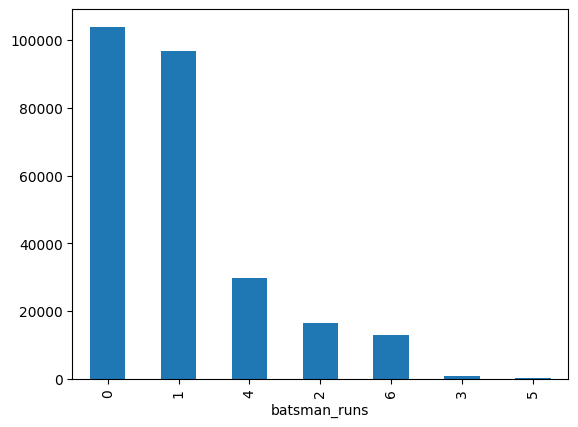

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical

# Load the dataset
file_path = '/content/newfullyFeaturedfinalFileUpdated (1).csv'
df = pd.read_csv(file_path, low_memory=False)

# Select relevant features and target
features = [
    'over', 'ball', 'batsman_runs', 'total_runs_x',
    'wickets_in_hand', 'recent_avg_runs', 'current_run_rate',
    'partnership_runs', 'overs_faced', 'cumulative_runs'
]

df = df[features]
# Check the distribution of the target variable
df['batsman_runs'].value_counts().plot(kind='bar')

# Normalize the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Prepare the data for LSTM
sequence_length = 10  # Number of previous data points to consider for each prediction

X = []
y = []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i])
    y.append(df_scaled[i, 2])  # 'batsman_runs' is the target

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Reshape y for LSTM (if predicting a categorical output)
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict the next action for the entire test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted classes

# Compare predictions with actual values
actual_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to classes

# Create a DataFrame to store predictions and actual values
comparison_df = pd.DataFrame({
    'Predicted Runs': y_pred_classes,
    'Actual Runs': actual_classes
})

# Display some of the comparisons
print(comparison_df.head(5))

# Predict the outcome for a specific ball, e.g., the 6th ball in the test set
specific_ball_index = 6
specific_ball_prediction = y_pred_classes[specific_ball_index]
actual_ball_result = actual_classes[specific_ball_index]

print(f"Prediction for the 6th ball: {specific_ball_prediction} runs")
print(f"Actual result for the 6th ball: {actual_ball_result} runs")


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# Load and preprocess the data as before
file_path = '/content/newfullyFeaturedfinalFileUpdated (1).csv'
df = pd.read_csv(file_path, low_memory=False)

# Select relevant features and target
features = [
    'over', 'ball', 'batsman_runs', 'total_runs_x',
    'wickets_in_hand', 'recent_avg_runs', 'current_run_rate',
    'partnership_runs', 'overs_faced', 'cumulative_runs'
]

df = df[features]

# Normalize the features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Prepare the data for LSTM
sequence_length = 10  # Number of previous data points to consider for each prediction

X = []
y = []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i])
    y.append(int(df_scaled[i, 2]))  # Convert target to integer if it's not already

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Ensure y_train is treated as categorical
y_train = y_train.astype(int)

# Apply SMOTE to the training set
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape X_train back to its original shape for LSTM
X_train_resampled = X_train_resampled.reshape(-1, sequence_length, X_train.shape[2])

# One-hot encode y_train_resampled and y_test
y_train_resampled = to_categorical(y_train_resampled, num_classes=len(np.unique(y)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y)))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=y_train_resampled.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the resampled data
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict the next action for the entire test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted classes

# Compare predictions with actual values
actual_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to classes

# Create a DataFrame to store predictions and actual values
comparison_df = pd.DataFrame({
    'Predicted Runs': y_pred_classes,
    'Actual Runs': actual_classes
})

# Display some of the comparisons
print(comparison_df.head(5))

# Predict the outcome for a specific ball, e.g., the 6th ball in the test set
specific_ball_index = 6
specific_ball_prediction = y_pred_classes[specific_ball_index]
actual_ball_result = actual_classes[specific_ball_index]

print(f"Prediction for the 6th ball: {specific_ball_prediction} runs")
print(f"Actual result for the 6th ball: {actual_ball_result} runs")


Mean Squared Error: 0.03426766894536655
R^2 Score: 0.9871441358663591
Ball 1: Batsman 102 scored 0 runs
Ball 2: Batsman 102 scored 0 runs
Ball 3: Batsman 102 scored 0 runs
Ball 4: Batsman 102 scored 0 runs
Ball 5: Batsman 102 scored 0 runs
Ball 6: Batsman 102 scored 0 runs


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/newfullyFeaturedfinalFileUpdated (1).csv'  # Update this path if necessary
df = pd.read_csv(file_path)

# 1. Batsman Form: Calculate the average runs in the last few overs or matches
def calculate_batsman_form(df, window_size=5):
    df['batsman_form'] = df.groupby('batter')['batsman_runs'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return df

# 2. Bowler Form: Calculate the average runs conceded by the bowler in the last few overs or matches
def calculate_bowler_form(df, window_size=5):
    df['bowler_form'] = df.groupby('bowler')['batsman_runs'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return df

# 3. Current Run Rate: Calculate the current run rate of the innings
def calculate_run_rate(df):
    df['current_run_rate'] = df.groupby('match_id')['batsman_runs'].cumsum() / df['over']
    df['current_run_rate'] = df['current_run_rate'].replace(np.inf, 0)  # Handle division by zero
    return df

# 4. Required Run Rate: Calculate the required run rate (only applicable in chasing innings)
def calculate_required_run_rate(df, total_runs=200):  # Assume a default target of 200, can be adjusted or made dynamic
    df['required_run_rate'] = (total_runs - df.groupby('match_id')['batsman_runs'].cumsum()) / (20 - df['over'])  # Assuming a 20 over match
    df['required_run_rate'] = df['required_run_rate'].replace(np.inf, 0)  # Handle division by zero
    df['required_run_rate'] = df['required_run_rate'].replace(-np.inf, 0)  # Handle division by zero
    return df

# 5. Pressure Situations: Adding features for pressure situations
def calculate_pressure_situations(df):
    df['is_pressure'] = (df['required_run_rate'] > df['current_run_rate']).astype(int)
    return df

# Apply the feature engineering functions
df = calculate_batsman_form(df)
df = calculate_bowler_form(df)
df = calculate_run_rate(df)
df = calculate_required_run_rate(df)
df = calculate_pressure_situations(df)

# Drop any rows with NaN values that might have been introduced during rolling operations
df.dropna(inplace=True)

# Display the first few rows of the enhanced dataset
df.head()

# Optionally, save the enhanced dataset to a new CSV file
enhanced_file_path = '/content/enhanced_features_dataset.csv'
df.to_csv(enhanced_file_path, index=False)
print(f"Enhanced dataset saved to {enhanced_file_path}")


Enhanced dataset saved to /content/enhanced_features_dataset.csv


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/newfullyFeaturedfinalFileUpdated (1).csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Filter the DataFrame to keep only rows where 'inning' is 1 or 2
filtered_df = df[(df['inning'] == 1) | (df['inning'] == 2)]

# Save the filtered DataFrame back to a CSV file
output_path = '/content/newfullyFeaturedfinalFileUpd (1).csv'  # Replace with your desired output file path
filtered_df.to_csv(output_path, index=False)

print(f"Filtered data saved to {output_path}")


Filtered data saved to /content/inningsRemoved.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

target = 'batsman_runs'

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Check if the specified over exists in the dataset
filtered_data = data[(data['match_id'] == match_id) &
                     (data['inning'] == inning) &
                     (data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Filter the dataset for the selected match and innings
    match_data = data[(data['match_id'] == match_id) & (data['inning'] == inning)]

    # Create feature and target datasets
    X = match_data[features]
    y = match_data[target]

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    data_0 = data_combined[data_combined.batsman_runs == 0]
    data_1 = data_combined[data_combined.batsman_runs == 1]
    data_6 = data_combined[data_combined.batsman_runs == 6]
    data_2 = data_combined[data_combined.batsman_runs == 2]
    data_4 = data_combined[data_combined.batsman_runs == 4]

    # Determine the majority class size
    majority_size = max(len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    # Resample each class to the majority size
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target
    X_balanced = data_balanced.drop('batsman_runs', axis=1)
    y_balanced = data_balanced['batsman_runs']

    # Split the data into training and testing sets (80:20 split)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_bal_scaled = scaler.transform(X_test_bal)

    # Define a Logistic Regression model
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

    # Train the model
    lr_model.fit(X_train_bal_scaled, y_train_bal)

    # Predict on the test set
    y_pred_bal = lr_model.predict(X_test_bal_scaled)

    # Evaluate the model
    accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
    report_bal = classification_report(y_test_bal, y_pred_bal)

    # Output the results
    print(f'Accuracy: {accuracy_bal}')
    print('Classification Report:')
    print(report_bal)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over
    predicted_over_runs = lr_model.predict(over_features_scaled)

    # Compare the predicted runs with the actual runs
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs
    })

    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Enter the Match ID: 1426266
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 1
batsman_runs
0    53
1    49
4    13
6     7
2     5
Name: count, dtype: int64
Accuracy: 0.7169811320754716
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.50      0.46      0.48        13
           2       0.73      1.00      0.84         8
           4       0.90      1.00      0.95         9
           6       1.00      0.91      0.95        11

    accuracy                           0.72        53
   macro avg       0.73      0.76      0.74        53
weighted avg       0.71      0.72      0.71        53

Predictions for Match ID 1426266, Inning 1, Over 1:
        Ball  Actual Runs  Predicted Runs
250267     1            0               0
250268     2            0               1
250269     3            0               1
250270     4            6               4
250271     5            1    

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Combine `batsman_runs` and `is_wicket` into a single target column
data['target'] = data.apply(lambda row: 'W' if row['is_wicket'] == 1 else str(int(row['batsman_runs'])), axis=1)

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Check if the specified over exists in the dataset
filtered_data = data[(data['match_id'] == match_id) &
                     (data['inning'] == inning) &
                     (data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Filter the dataset for the selected match and innings
    match_data = data[(data['match_id'] == match_id) & (data['inning'] == inning)]

    # Create feature and target datasets
    X = match_data[features]
    y = match_data['target']

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    data_W = data_combined[data_combined.target == 'W']
    data_0 = data_combined[data_combined.target == '0']
    data_1 = data_combined[data_combined.target == '1']
    data_6 = data_combined[data_combined.target == '6']
    data_2 = data_combined[data_combined.target == '2']
    data_4 = data_combined[data_combined.target == '4']

    # Determine the majority class size
    majority_size = max(len(data_W), len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    # Resample each class to the majority size
    data_W_resampled = resample(data_W, replace=True, n_samples=majority_size, random_state=42)
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_W_resampled, data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Split the data into training and testing sets (80:20 split)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_bal_scaled = scaler.transform(X_test_bal)

    # Define a Logistic Regression model
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

    # Train the model
    lr_model.fit(X_train_bal_scaled, y_train_bal)

    # Predict on the test set
    y_pred_bal = lr_model.predict(X_test_bal_scaled)

    # Evaluate the model
    accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
    report_bal = classification_report(y_test_bal, y_pred_bal)

    # Output the results
    print(f'Accuracy: {accuracy_bal}')
    print('Classification Report:')
    print(report_bal)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over
    predicted_over_runs = lr_model.predict(over_features_scaled)

    # Add information about extras and wickets to the display
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Enter the Match ID: 1426266
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 15
target
1    49
0    46
4    13
6     7
W     7
2     5
Name: count, dtype: int64
Accuracy: 0.7627118644067796
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.73      0.80      0.76        10
           2       0.73      1.00      0.84         8
           4       0.92      0.92      0.92        12
           6       0.86      0.86      0.86         7
           W       0.62      0.91      0.74        11

    accuracy                           0.76        59
   macro avg       0.81      0.78      0.74        59
weighted avg       0.81      0.76      0.73        59

Predictions for Match ID 1426266, Inning 1, Over 15:
        Ball  Actual Runs Predicted Runs Extras Wicket
250356     1            1              1              
250357     2            0              0              
250358     3    

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Combine `batsman_runs` and `is_wicket` into a single target column
data['target'] = data.apply(lambda row: 'W' if row['is_wicket'] == 1 else str(int(row['batsman_runs'])), axis=1)

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID (e.g., 10 for 10th match): "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Filter data for training: use only data from the first 'match_id' matches
train_data = data[data['match_id'] <= match_id]

# Further filter the dataset to check if the specified over exists in the data
filtered_data = train_data[(train_data['match_id'] == match_id) &
                           (train_data['inning'] == inning) &
                           (train_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Split train_data into features and target
    X = train_data[features]
    y = train_data['target']

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Resample classes to balance the dataset
    data_W = data_combined[data_combined.target == 'W']
    data_0 = data_combined[data_combined.target == '0']
    data_1 = data_combined[data_combined.target == '1']
    data_6 = data_combined[data_combined.target == '6']
    data_2 = data_combined[data_combined.target == '2']
    data_4 = data_combined[data_combined.target == '4']

    majority_size = max(len(data_W), len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    data_W_resampled = resample(data_W, replace=True, n_samples=majority_size, random_state=42)
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_W_resampled, data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target for balanced data
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Apply PCA
    pca = PCA(n_components=10)  # Adjust the number of components as necessary
    X_balanced_pca = pca.fit_transform(X_balanced_scaled)

    # Split the data into training and testing sets (80:20 split)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced_pca, y_balanced, test_size=0.2, random_state=42)

    # Define models
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

    # Create an ensemble model using VotingClassifier
    ensemble_model = VotingClassifier(estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ], voting='soft')

    # Train the ensemble model
    ensemble_model.fit(X_train_bal, y_train_bal)

    # Predict on the test set
    y_pred_ensemble = ensemble_model.predict(X_test_bal)

    # Evaluate the ensemble model
    accuracy_ensemble = accuracy_score(y_test_bal, y_pred_ensemble)
    report_ensemble = classification_report(y_test_bal, y_pred_ensemble)

    # Output the results
    print(f'Ensemble Model Accuracy: {accuracy_ensemble}')
    print('Ensemble Model Classification Report:')
    print(report_ensemble)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]
    over_features_scaled = scaler.transform(over_features)
    over_features_pca = pca.transform(over_features_scaled)

    # Predict the runs for each ball in the over
    predicted_over_runs_ensemble = ensemble_model.predict(over_features_pca)

    # Add information about extras and wickets to the display
    actual_vs_predicted_ensemble = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['target'],
        'Predicted Runs': predicted_over_runs_ensemble,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    print(f'Ensemble Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted_ensemble)


Enter the Match ID (e.g., 10 for 10th match): 1426307
Enter the Inning Number (1 or 2): 2
Enter the Over Number: 3
target
1    96025
0    91052
4    29722
2    16379
6    12982
W    12869
3      781
5       65
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:06:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Model Accuracy: 0.8898030026902717
Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.77     19093
           1       0.84      0.70      0.76     19183
           2       0.92      0.96      0.94     19305
           4       0.99      0.96      0.98     19106
           6       0.97      0.99      0.98     19351
           W       0.80      1.00      0.89     19192

    accuracy                           0.89    115230
   macro avg       0.89      0.89      0.89    115230
weighted avg       0.89      0.89      0.89    115230

Ensemble Predictions for Match ID 1426307, Inning 2, Over 3:
        Ball Actual Runs Predicted Runs   Extras Wicket
259771     1           0              2                
259772     2           0              0  No Ball       
259773     3           0              1                
259774     4           1              1                
259775     5           0          

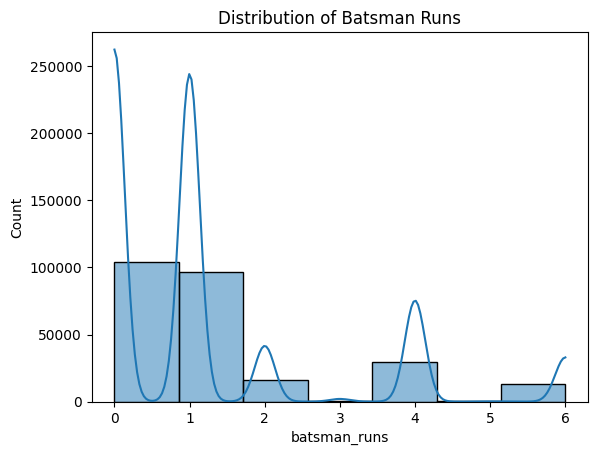

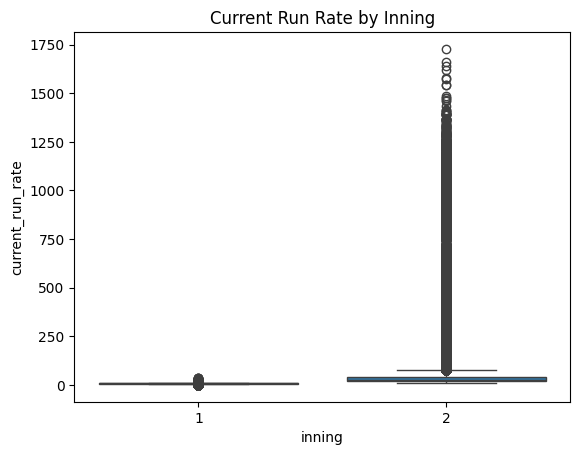

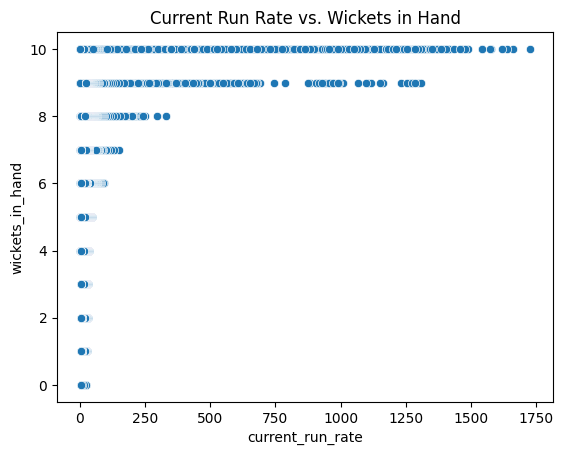

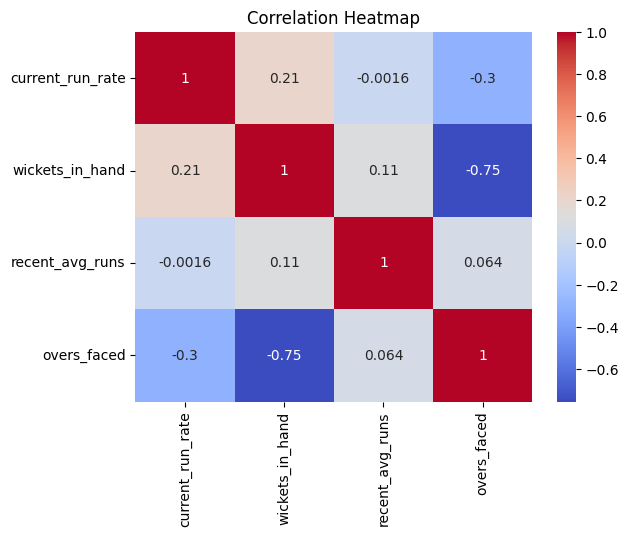

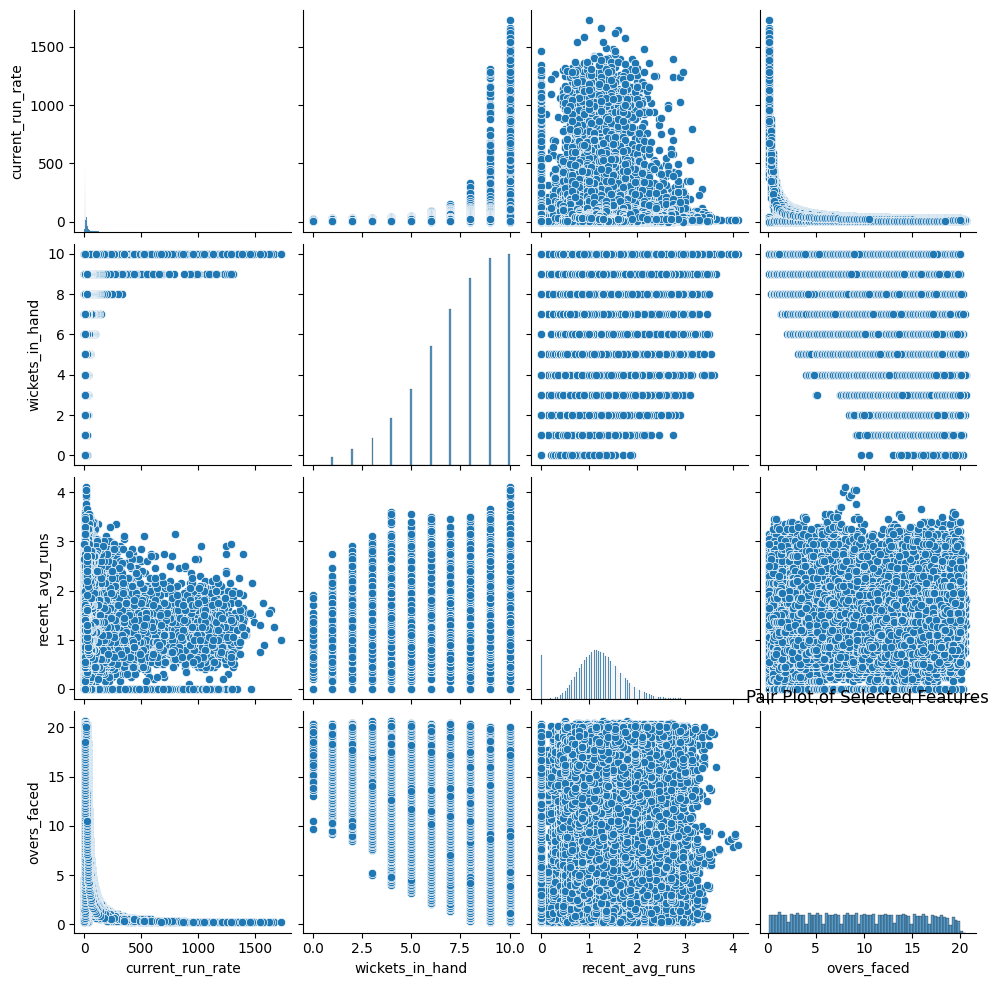

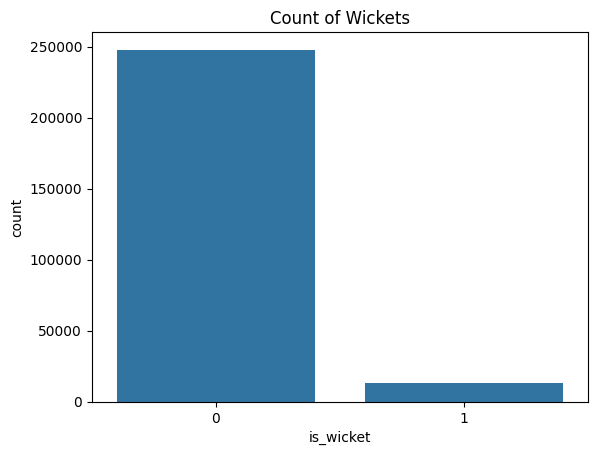

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# 1. Histogram of batsman runs
sns.histplot(data['batsman_runs'], bins=7, kde=True)
plt.title('Distribution of Batsman Runs')
plt.show()

# 2. Box plot of current run rate by innings
sns.boxplot(x='inning', y='current_run_rate', data=data)
plt.title('Current Run Rate by Inning')
plt.show()

# 3. Scatter plot of current run rate vs. wickets in hand
sns.scatterplot(x='current_run_rate', y='wickets_in_hand', data=data)
plt.title('Current Run Rate vs. Wickets in Hand')
plt.show()

# 4. Correlation heatmap of numerical features
corr = data[['current_run_rate', 'wickets_in_hand', 'recent_avg_runs', 'overs_faced']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. Pair plot for selected numerical features
sns.pairplot(data[['current_run_rate', 'wickets_in_hand', 'recent_avg_runs', 'overs_faced']])
plt.title('Pair Plot of Selected Features')
plt.show()

# 6. Count plot of wickets
sns.countplot(x='is_wicket', data=data)
plt.title('Count of Wickets')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Combine `batsman_runs` and `is_wicket` into a single target column
data['target'] = data.apply(lambda row: 'W' if row['is_wicket'] == 1 else str(int(row['batsman_runs'])), axis=1)

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Check if the specified over exists in the dataset
filtered_data = data[(data['match_id'] == match_id) &
                     (data['inning'] == inning) &
                     (data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Filter the dataset for the selected match and innings
    match_data = data[(data['match_id'] == match_id) & (data['inning'] == inning)]

    # Create feature and target datasets
    X = match_data[features]
    y = match_data['target']

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    data_W = data_combined[data_combined.target == 'W']
    data_0 = data_combined[data_combined.target == '0']
    data_1 = data_combined[data_combined.target == '1']
    data_6 = data_combined[data_combined.target == '6']
    data_2 = data_combined[data_combined.target == '2']
    data_4 = data_combined[data_combined.target == '4']

    # Determine the majority class size
    majority_size = max(len(data_W), len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    # Resample each class to the majority size
    data_W_resampled = resample(data_W, replace=True, n_samples=majority_size, random_state=42)
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_W_resampled, data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Split the data into training and testing sets (80:20 split)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_bal_scaled = scaler.transform(X_test_bal)

    # Define a Logistic Regression model
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

    # Train the model
    lr_model.fit(X_train_bal_scaled, y_train_bal)

    # Predict on the test set
    y_pred_bal = lr_model.predict(X_test_bal_scaled)

    # Evaluate the model
    accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
    report_bal = classification_report(y_test_bal, y_pred_bal)

    # Output the results
    print(f'Accuracy: {accuracy_bal}')
    print('Classification Report:')
    print(report_bal)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over
    predicted_over_runs = lr_model.predict(over_features_scaled)

    # Add information about extras and wickets to the display
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    # Add the "upper hand" column based on the predicted runs
    actual_vs_predicted['Upper Hand'] = actual_vs_predicted['Predicted Runs'].apply(
        lambda x: 'Batsman' if x in ['4', '2', '3', '6'] else 'Bowler'
    )

    # Output the DataFrame with the new column
    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Enter the Match ID: 1254095
Enter the Inning Number (1 or 2): 2
Enter the Over Number: 17
target
0    48
1    42
4    12
2    10
W     6
6     4
Name: count, dtype: int64
Accuracy: 0.8620689655172413
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       1.00      0.33      0.50         9
           2       0.71      1.00      0.83        10
           4       1.00      1.00      1.00         8
           6       1.00      1.00      1.00        15
           W       0.91      1.00      0.95        10

    accuracy                           0.86        58
   macro avg       0.87      0.83      0.82        58
weighted avg       0.89      0.86      0.85        58

Predictions for Match ID 1254095, Inning 2, Over 17:
        Ball  Actual Runs Predicted Runs Extras Wicket Upper Hand
205934     1            4              4                  Batsman
205935     2            0              2         

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Combine `batsman_runs` and `is_wicket` into a single target column
data['target'] = data.apply(lambda row: 'W' if row['is_wicket'] == 1 else str(int(row['batsman_runs'])), axis=1)

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Check if the specified over exists in the dataset
filtered_data = data[(data['match_id'] == match_id) &
                     (data['inning'] == inning) &
                     (data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Filter the dataset for the selected match and innings
    match_data = data[(data['match_id'] == match_id) & (data['inning'] == inning)]

    # Create feature and target datasets
    X = match_data[features]
    y = match_data['target']

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    data_W = data_combined[data_combined.target == 'W']
    data_0 = data_combined[data_combined.target == '0']
    data_1 = data_combined[data_combined.target == '1']
    data_6 = data_combined[data_combined.target == '6']
    data_2 = data_combined[data_combined.target == '2']
    data_4 = data_combined[data_combined.target == '4']

    # Determine the majority class size
    majority_size = max(len(data_W), len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    # Resample each class to the majority size
    data_W_resampled = resample(data_W, replace=True, n_samples=majority_size, random_state=42)
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_W_resampled, data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Define a Logistic Regression model
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)

    # Perform 5-fold Cross-Validation and predict on each fold
    y_pred_cv = cross_val_predict(lr_model, X_balanced_scaled, y_balanced, cv=5)

    # Print the cross-validation accuracy scores
    cross_val_scores = cross_val_score(lr_model, X_balanced_scaled, y_balanced, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
    print(f'Average Cross-Validation Accuracy: {cross_val_scores.mean()}')

    # Generate a classification report
    report_cv = classification_report(y_balanced, y_pred_cv)
    print("Classification Report for Cross-Validation:")
    print(report_cv)

    # Train the model on the whole dataset after cross-validation
    lr_model.fit(X_balanced_scaled, y_balanced)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over
    predicted_over_runs = lr_model.predict(over_features_scaled)

    # Add information about extras and wickets to the display
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    # Add the "upper hand" column based on the predicted runs
    actual_vs_predicted['Upper Hand'] = actual_vs_predicted['Predicted Runs'].apply(
        lambda x: 'Batsman' if x in ['4', '2', '3', '6'] else 'Bowler'
    )

    # Output the DataFrame with the new column
    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Enter the Match ID: 1426312
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 3
target
0    52
1    38
W    10
4     8
2     6
6     3
Name: count, dtype: int64
Cross-Validation Accuracy Scores: [0.63492063 0.71428571 0.69354839 0.72580645 0.70967742]
Average Cross-Validation Accuracy: 0.6956477214541732
Classification Report for Cross-Validation:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38        52
           1       0.50      0.42      0.46        52
           2       0.51      0.56      0.53        52
           4       1.00      1.00      1.00        52
           6       1.00      1.00      1.00        52
           W       0.69      0.85      0.76        52

    accuracy                           0.70       312
   macro avg       0.69      0.70      0.69       312
weighted avg       0.69      0.70      0.69       312

Predictions for Match ID 1426312, Inning 1, Over 3:
        Ball  Actual Runs Predicted Runs Extra

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Input match_id, inning, and over from the user
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Check if the specified over exists in the dataset
filtered_data = data[(data['match_id'] == match_id) &
                     (data['inning'] == inning) &
                     (data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Filter the dataset for the selected match and innings
    match_data = data[(data['match_id'] == match_id) & (data['inning'] == inning)]

    # Create feature and target datasets
    X = match_data[features]
    y = match_data['target']

    # Display the original distribution of target classes
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    data_W = data_combined[data_combined.target == 'W']
    data_0 = data_combined[data_combined.target == '0']
    data_1 = data_combined[data_combined.target == '1']
    data_6 = data_combined[data_combined.target == '6']
    data_2 = data_combined[data_combined.target == '2']
    data_4 = data_combined[data_combined.target == '4']

    # Determine the majority class size
    majority_size = max(len(data_W), len(data_0), len(data_1), len(data_6), len(data_2), len(data_4))

    # Resample each class to the majority size
    data_W_resampled = resample(data_W, replace=True, n_samples=majority_size, random_state=42)
    data_0_resampled = resample(data_0, replace=True, n_samples=majority_size, random_state=42)
    data_1_resampled = resample(data_1, replace=True, n_samples=majority_size, random_state=42)
    data_6_resampled = resample(data_6, replace=True, n_samples=majority_size, random_state=42)
    data_2_resampled = resample(data_2, replace=True, n_samples=majority_size, random_state=42)
    data_4_resampled = resample(data_4, replace=True, n_samples=majority_size, random_state=42)

    # Combine the resampled data
    data_balanced = pd.concat([data_W_resampled, data_0_resampled, data_1_resampled, data_6_resampled, data_2_resampled, data_4_resampled])

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Perform 5-fold Cross-Validation and predict on each fold
    y_pred_cv = cross_val_predict(rf_model, X_balanced_scaled, y_balanced, cv=5)

    # Print the cross-validation accuracy scores
    cross_val_scores = cross_val_score(rf_model, X_balanced_scaled, y_balanced, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
    print(f'Average Cross-Validation Accuracy: {cross_val_scores.mean()}')

    # Generate a classification report
    report_cv = classification_report(y_balanced, y_pred_cv)
    print("Classification Report for Cross-Validation:")
    print(report_cv)

    # Train the model on the whole dataset after cross-validation
    rf_model.fit(X_balanced_scaled, y_balanced)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over using the Random Forest model
    predicted_over_runs = rf_model.predict(over_features_scaled)

    # Add information about extras and wickets to the display
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    # Add the "upper hand" column based on the predicted runs
    actual_vs_predicted['Upper Hand'] = actual_vs_predicted['Predicted Runs'].apply(
        lambda x: 'Batsman' if x in ['4', '2', '3', '6'] else 'Bowler'
    )

    # Output the DataFrame with the new column
    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 2
Enter the Over Number: 3
target
0          50
1          42
4          13
W           7
6           5
2           5
No Ball     1
Leg Bye     1
Name: count, dtype: int64
Cross-Validation Accuracy Scores: [0.9        0.9        0.85       0.88333333 0.96666667]
Average Cross-Validation Accuracy: 0.9
Classification Report for Cross-Validation:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73        50
           1       0.78      0.78      0.78        50
           2       0.93      1.00      0.96        50
           4       1.00      0.96      0.98        50
           6       0.96      1.00      0.98        50
           W       0.89      1.00      0.94        50

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

Predictions for Match ID 1426311, Inning 2, Over 

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Perform 5-fold Cross-Validation and predict on each fold
    y_pred_cv = cross_val_predict(rf_model, X_balanced_scaled, y_balanced, cv=5)

    # Train the model on the whole dataset after cross-validation
    rf_model.fit(X_balanced_scaled, y_balanced)

    # Predict the runs for the user-specified over
    over_features = filtered_data[features]

    # Scale the features using the previously fitted scaler
    over_features_scaled = scaler.transform(over_features)

    # Predict the runs for each ball in the over using the Random Forest model
    predicted_over_runs = rf_model.predict(over_features_scaled)

    # Add information about extras and wickets to the display
    actual_vs_predicted = pd.DataFrame({
        'Ball': filtered_data['ball'],
        'Actual Runs': filtered_data['batsman_runs'],
        'Predicted Runs': predicted_over_runs,
        'Extras': filtered_data['extras_type'].replace({0: '', 1: 'Wide', 2: 'No Ball', 3: 'Leg Bye', 4: 'Bye'}),
        'Wicket': filtered_data['is_wicket'].replace({0: '', 1: 'Wicket'})
    })

    # Add the "upper hand" column based on the predicted runs
    actual_vs_predicted['Upper Hand'] = actual_vs_predicted['Predicted Runs'].apply(
        lambda x: 'Batsman' if x in ['4', '2', '3', '6'] else 'Bowler'
    )

    # Output the DataFrame with the new column
    print(f'Predictions for Match ID {match_id}, Inning {inning}, Over {over_number}:')
    print(actual_vs_predicted)


Original Target Distribution (up to and including match_id):
target
1          95954
0          86184
4          29676
2          16354
6          12938
W          12911
No Ball     3986
Leg Bye     1055
3            782
Wide         668
5             65
Bye            2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64


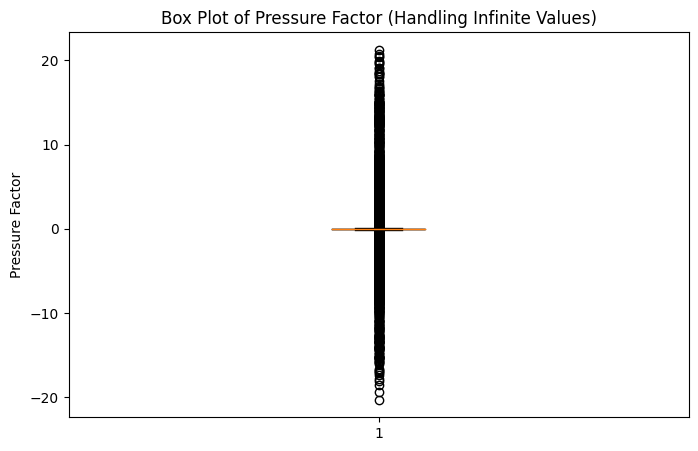

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/content/newfullyFeaturedfinalFileUpdated (1).csv')  # Adjust path as needed
# Assuming your dataframe is called 'data'
# Replace infinite values with NaN to handle them in plotting
data['pressure_factor'] = data['pressure_factor'].replace([np.inf, -np.inf], np.nan)

# Plot a box plot for 'pressure factor'
plt.figure(figsize=(8, 5))
plt.boxplot(data['pressure_factor'].dropna())
plt.title('Box Plot of Pressure Factor (Handling Infinite Values)')
plt.ylabel('Pressure Factor')
plt.show()
